In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sherpa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from tqdm.notebook import tqdm
from torchviz import make_dot

import logging 
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logger.info("IS_CRITICAL uuuhh")

torch.__version__

'1.4.0a0+fe76af9'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#path = "drive/My Drive/AML/"
path = ""

df = pd.read_csv(path + "pmsm_temperature_data.csv")

In [4]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                                axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                                axis=1).max()

df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [5]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7, 8, 9, 10]

def dataloader(data, length, shuffle=True, out=1):
    while True:
    # genera una lista di (i_serie, i_obs)
        tuples = [[(df_i, i) for i, x in enumerate(data[df_i]) if i >= length + out]
                  for df_i, _ in enumerate(data)]
        tuples = sum(tuples, [])  # flattenizza
        # shuffle
        if shuffle:
            np.random.shuffle(tuples)

        # yielda le osservazioni
        for df_i, i in tuples:
            X_lagged = data[df_i][(i - length - out):(i - out + 1), FEATURES]
            y = data[df_i][(i-out):(i), TARGET]
            yield X_lagged, y
            

def new_loss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1)*F.relu(target - 0.5)
        return torch.mean(weights*((output - target)**2))
    
    return high_low_loss

In [6]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
    return(output)

class Reg_CNN_Net(nn.Module):
    def __init__(self, features, seq_len, 
                 conv1, conv2, kernel1, kernel2,
                 h1, h2, out):
        super(Reg_CNN_Net, self).__init__()
        #self.h1 = h1
        self.h2 = h2
        #self.conv1 = conv1
        self.conv2 = conv2

        self.features = features
        self.seq_len = seq_len
        
        self.c1 = nn.Conv1d(self.seq_len, conv1, kernel1)
        
        h0 = outputSize(self.features, kernel1, 1, 0)*conv1
        if conv2 != 0:
            self.c2 = nn.Conv1d(conv1, conv2, kernel2)
        
        
            h0 = outputSize(outputSize(self.features, kernel1, 1, 0), 
                            kernel2, 1 ,0)*conv2

        self.fc1 = nn.Linear(h0, h1)
        

        if self.h2 != 0:
            self.fc2 = nn.Linear(h1, h2)
            
            self.out = nn.Linear(h2, out)
        else:
            self.out = nn.Linear(h1, out)

    def forward(self, x):
        batch_size, _, _ = x.shape 
        
        x1 = F.relu(self.c1(x))
        if self.conv2!=0:
            x = F.relu(self.c2(x1))
        else:
            x = x1
        
        x = x.view(batch_size,-1)
        
        x = F.relu(self.fc1(x))
        if self.h2 != 0:
            x = F.relu(self.fc2(x))
        return self.out(x)

In [8]:
parameters = [sherpa.Continuous('lr',[0.001,0.01]),
              sherpa.Discrete('conv1',[2,50]),
              sherpa.Discrete('conv2',[0,50]),
              sherpa.Discrete('kernel1',[2,4]),
              sherpa.Discrete('kernel2',[2,4]),
              sherpa.Discrete('h1',[16,128]),
              sherpa.Discrete('h2',[0,64]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [9]:
look_back  = 20
best_score = 99999
feature    = 7

for trial in study:

    cnn = Reg_CNN_Net(features=feature, seq_len=look_back+1,
                     conv1 = int(trial.parameters["conv1"]),
                     conv2 = int(trial.parameters["conv2"]),
                     kernel1 = int(trial.parameters["kernel1"]),
                     kernel2 = int(trial.parameters["kernel2"]),
                     h1=int(trial.parameters["h1"]),
                     h2=int(trial.parameters["h2"]), out=4).to(device)
                     
    losses = []
    #just change here and you should get the other loss
    #criterion = customLoss(1,3)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=trial.parameters["lr"],
                                weight_decay=0.001)

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    cnn.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, look_back + 1, feature)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = cnn(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  
            
            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except Exception as e:
            print("This Happened happened", e)
            print(inpt.shape)
            print(x_batch.size())
            break
        
    
    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    cnn.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back + 1, feature)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = cnn(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    
    score = np.mean(criterion(torch.from_numpy(y_pred_all), 
                      torch.from_numpy(y_test)).numpy())
    #score = np.mean((y_pred_all - y_test)**2)
    if trial.id % 10 == 0:
        print("Now at Trial",trial.id)
    if score < best_score:
        best_score = score
        torch.save(cnn, path + "models/best_model_cnn_reg_new")
        print("ID:", trial.id,"New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN_reg_new.csv")

ID: 1 New Challanger with MSE on val: 0.013300095105733743 and confs: {'lr': 0.008822043392743159, 'conv1': 19, 'conv2': 45, 'kernel1': 3, 'kernel2': 2, 'h1': 50, 'h2': 48, 'batch_size': 1024}
ID: 2 New Challanger with MSE on val: 0.012706073042806387 and confs: {'lr': 0.001416927106621407, 'conv1': 42, 'conv2': 33, 'kernel1': 2, 'kernel2': 3, 'h1': 24, 'h2': 39, 'batch_size': 2048}
ID: 7 New Challanger with MSE on val: 0.012607956467847766 and confs: {'lr': 0.006019271654013545, 'conv1': 34, 'conv2': 13, 'kernel1': 2, 'kernel2': 3, 'h1': 125, 'h2': 26, 'batch_size': 2048}
Now at Trial 10
ID: 12 New Challanger with MSE on val: 0.012274132069676771 and confs: {'lr': 0.004355104767876115, 'conv1': 40.0, 'conv2': 40.0, 'kernel1': 2.0, 'kernel2': 2.0, 'h1': 19.0, 'h2': 12.0, 'batch_size': 512.0}
ID: 15 New Challanger with MSE on val: 0.01217795181002186 and confs: {'lr': 0.0032870608865502525, 'conv1': 44.0, 'conv2': 39.0, 'kernel1': 2.0, 'kernel2': 2.0, 'h1': 18.0, 'h2': 25.0, 'batch_size

In [10]:
best_model = torch.load(path + "models/best_model_cnn_reg_new")
results = pd.read_csv(path + "results/AutoML_CNN_reg_new.csv")
results = results[results["Status"]=="COMPLETED"]

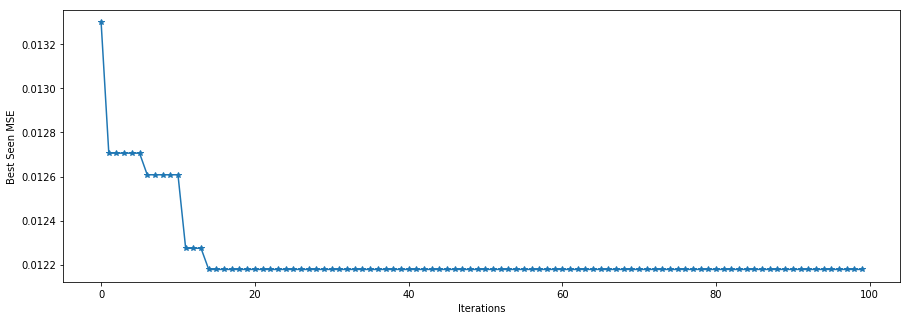

In [11]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [24]:
test_n = 1
look_back = 20

test_gen = dataloader([df_test[test_n].values], look_back, shuffle=False)
size = df_test[test_n].shape[0]

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, look_back + 1, 7)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_test = np.array(y_test).reshape(-1,4)
y_pred_all = y_pred_all.reshape(-1,4)

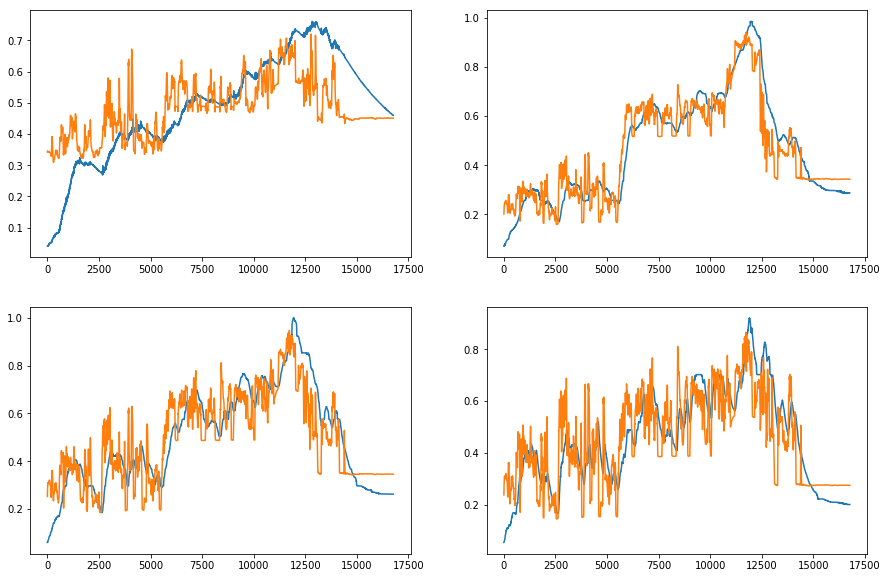

In [25]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:size - look_back - 1,0])
plt.plot(y_pred_all[:size - look_back - 1,0])

plt.subplot(222)
plt.plot(y_test[:size - look_back - 1,1])
plt.plot(y_pred_all[:size - look_back - 1,1])

plt.subplot(223)
plt.plot(y_test[:size - look_back - 1,2])
plt.plot(y_pred_all[:size - look_back - 1,2])

plt.subplot(224)
plt.plot(y_test[:size - look_back - 1,3])
plt.plot(y_pred_all[:size - look_back - 1,3])
plt.show()


plt.show()

In [26]:
np.mean((y_test - y_pred_all)**2)

0.012161763580752006

In [15]:
best_model

Reg_CNN_Net(
  (c1): Conv1d(21, 44, kernel_size=(2,), stride=(1,))
  (c2): Conv1d(44, 39, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=195, out_features=18, bias=True)
  (fc2): Linear(in_features=18, out_features=25, bias=True)
  (out): Linear(in_features=25, out_features=4, bias=True)
)

In [16]:
parameters = [sherpa.Continuous('lr',[0.001,0.01]),
              sherpa.Discrete('conv1',[2,7]),
              sherpa.Discrete('conv2',[0,7]),
              sherpa.Discrete('kernel1',[2,4]),
              sherpa.Discrete('kernel2',[2,4]),
              sherpa.Discrete('h1',[16,64]),
              sherpa.Discrete('h2',[0,64]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [17]:
look_back  = 20
best_score = 99999
feature    = 7


def customLoss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1) * F.relu(target - 0.5)
        return torch.mean(weights * ((output - target)**2))

    return high_low_loss

for trial in study:

    cnn = Reg_CNN_Net(features=feature, seq_len=look_back+1,
                     conv1 = int(trial.parameters["conv1"]),
                     conv2 = int(trial.parameters["conv2"]),
                     kernel1 = int(trial.parameters["kernel1"]),
                     kernel2 = int(trial.parameters["kernel2"]),
                     h1=int(trial.parameters["h1"]),
                     h2=int(trial.parameters["h2"]), out=4).to(device)
                     
    losses = []
    #just change here and you should get the other loss
    criterion = customLoss(1,3)
    #criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=trial.parameters["lr"],
                                weight_decay=0.001)

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    cnn.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, look_back + 1, feature)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = cnn(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  
            
            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except Exception as e:
            print("This Happened happened", e)
            print(inpt.shape)
            print(x_batch.size())
            break
        
    
    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    cnn.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back + 1, feature)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = cnn(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    
    score = np.mean(criterion(torch.from_numpy(y_pred_all), 
                      torch.from_numpy(y_test)).numpy())
    #score = np.mean((y_pred_all - y_test)**2)
    if trial.id % 10 == 0:
        print("Now at Trial",trial.id)
    if score < best_score:
        best_score = score
        torch.save(cnn, path + "models/best_model_cnn_reg_new_c_loss")
        print("ID:", trial.id,"New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN_reg_new_c_loss.csv")

ID: 1 New Challanger with MSE on val: 0.015467572036970715 and confs: {'lr': 0.004311504328118106, 'conv1': 5, 'conv2': 6, 'kernel1': 3, 'kernel2': 2, 'h1': 58, 'h2': 45, 'batch_size': 1024}
ID: 3 New Challanger with MSE on val: 0.015033430633921051 and confs: {'lr': 0.008886746842883545, 'conv1': 3, 'conv2': 3, 'kernel1': 2, 'kernel2': 2, 'h1': 40, 'h2': 59, 'batch_size': 512}
ID: 4 New Challanger with MSE on val: 0.014519279717056861 and confs: {'lr': 0.009249574037051511, 'conv1': 5, 'conv2': 5, 'kernel1': 3, 'kernel2': 3, 'h1': 30, 'h2': 12, 'batch_size': 1024}
Now at Trial 10
ID: 11 New Challanger with MSE on val: 0.014472061604743647 and confs: {'lr': 0.009441830089432137, 'conv1': 5.0, 'conv2': 6.0, 'kernel1': 3.0, 'kernel2': 3.0, 'h1': 31.0, 'h2': 13.0, 'batch_size': 1024.0}
Now at Trial 20
Now at Trial 30
ID: 34 New Challanger with MSE on val: 0.01441692986969273 and confs: {'lr': 0.006387676482399537, 'conv1': 5.0, 'conv2': 3.0, 'kernel1': 2.0, 'kernel2': 2.0, 'h1': 41.0, 'h2

In [7]:
best_model = torch.load(path + "models/best_model_cnn_reg_new_c_loss")
results = pd.read_csv(path + "results/AutoML_CNN_reg_new_c_loss.csv")
results = results[results["Status"]=="COMPLETED"]

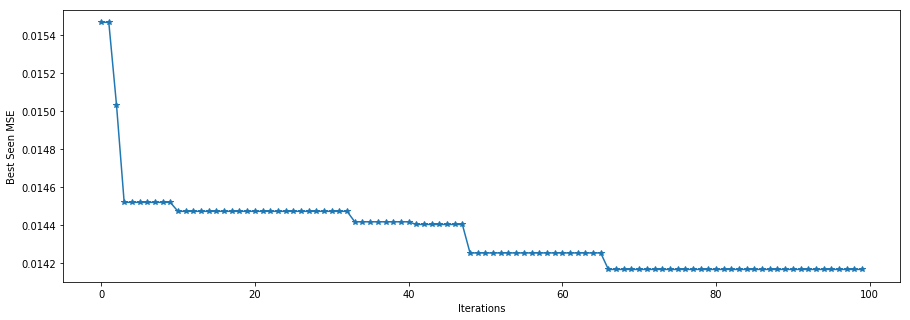

In [8]:
plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [9]:
test_n = 1
look_back = 20

test_gen = dataloader([df_test[test_n].values], look_back, shuffle=False)
size = df_test[test_n].shape[0]

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, look_back + 1, 7)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_test = np.array(y_test).reshape(-1,4)
y_pred_all = y_pred_all.reshape(-1,4)

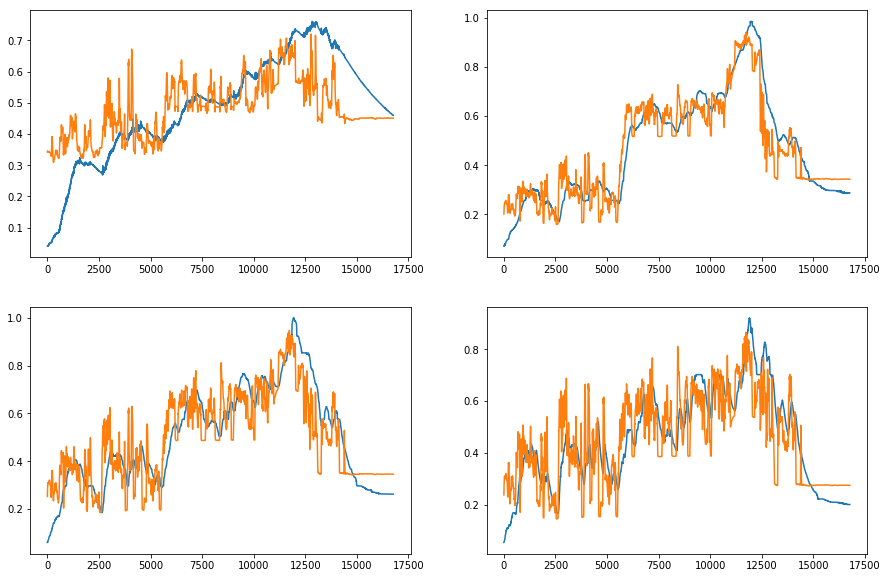

In [10]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:size - look_back - 1,0])
plt.plot(y_pred_all[:size - look_back - 1,0])

plt.subplot(222)
plt.plot(y_test[:size - look_back - 1,1])
plt.plot(y_pred_all[:size - look_back - 1,1])

plt.subplot(223)
plt.plot(y_test[:size - look_back - 1,2])
plt.plot(y_pred_all[:size - look_back - 1,2])

plt.subplot(224)
plt.plot(y_test[:size - look_back - 1,3])
plt.plot(y_pred_all[:size - look_back - 1,3])
plt.show()


plt.show()

In [11]:
np.mean((y_pred_all - y_test)**2)

0.012161763580752006

In [12]:
best_model

Reg_CNN_Net(
  (c1): Conv1d(21, 4, kernel_size=(2,), stride=(1,))
  (c2): Conv1d(4, 7, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=35, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=13, bias=True)
  (out): Linear(in_features=13, out_features=4, bias=True)
)

# LSTM
 

In [13]:
class LSTM_Net(nn.Module):
    def __init__(self, features, hidden, h1, h2, out):
        super(LSTM_Net, self).__init__()
        self.h1 = h1
        self.h2 = h2

        self.hidden_size = hidden
        self.features = features

        self.lstm = nn.LSTM(self.features, self.hidden_size, 1, #feature_size, hidden_size, num_layer
                            batch_first = True) 
        self.fc1 = nn.Linear(self.hidden_size, 
                                h1)
        self.out = nn.Linear(h1, out)

        if self.h2 != 0:
            self.fc2 = nn.Linear(h1, h2)
            self.out = nn.Linear(h2, out)
        
        #we do it stateless so there is no need for the hidden_state
        #self.hidden = None #torch.randn(1, ??, self.hidden) #num_layer, batch, hidden_size

    def forward(self, x):
        batch_size, _, _ = x.shape 
        
        x, _ =  self.lstm(x)
        x = F.tanh(x[:,-1].view(batch_size, -1))
        
        x = F.relu(self.fc1(x))
        if self.h2 != 0:
            x = F.relu(self.fc2(x))
        return self.out(x)

In [34]:
parameters = [sherpa.Discrete('lstm_hidden',[40,140]),
              sherpa.Discrete('hidden_unit1',[16,64]),
              sherpa.Discrete('hidden_unit2',[0,64]),
              sherpa.Continuous('lr',[0.0005,0.005]),
              sherpa.Choice('batch_size',[512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [35]:
look_back = 60
best_score = 99999

for trial in study:
    lstm = LSTM_Net(features=7, hidden=int(trial.parameters["lstm_hidden"]), 
                  h1=int(trial.parameters["hidden_unit1"]), 
                  h2=int(trial.parameters["hidden_unit2"]),out=4).to(device)

    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)

        inpt = np.array(X_train).reshape(-1, look_back + 1, 7)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break
        
        

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back + 1, 7)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_lstm_second_task")
        print("ID:", trial.id, "New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    if trial.id % 10 ==0:
        print("I am at",trial.id)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_LSTM_second_task.csv")

ID: 1 New Challanger with MSE on val: 0.012549797495289665 and confs: {'lstm_hidden': 129, 'hidden_unit1': 55, 'hidden_unit2': 27, 'lr': 0.004126176549415895, 'batch_size': 512}
ID: 2 New Challanger with MSE on val: 0.011574891470106926 and confs: {'lstm_hidden': 82, 'hidden_unit1': 20, 'hidden_unit2': 34, 'lr': 0.004915952247713884, 'batch_size': 1024}
I am at 10
ID: 13 New Challanger with MSE on val: 0.011562988997821837 and confs: {'lstm_hidden': 84.0, 'hidden_unit1': 23.0, 'hidden_unit2': 42.0, 'lr': 0.005, 'batch_size': 1024.0}
I am at 20
ID: 21 New Challanger with MSE on val: 0.011409663682124312 and confs: {'lstm_hidden': 86.0, 'hidden_unit1': 24.0, 'hidden_unit2': 40.0, 'lr': 0.005, 'batch_size': 1024.0}
I am at 30
ID: 31 New Challanger with MSE on val: 0.011051454381158966 and confs: {'lstm_hidden': 78.0, 'hidden_unit1': 20.0, 'hidden_unit2': 35.0, 'lr': 0.005, 'batch_size': 1024.0}
I am at 40
ID: 42 New Challanger with MSE on val: 0.010872522830789932 and confs: {'lstm_hidden

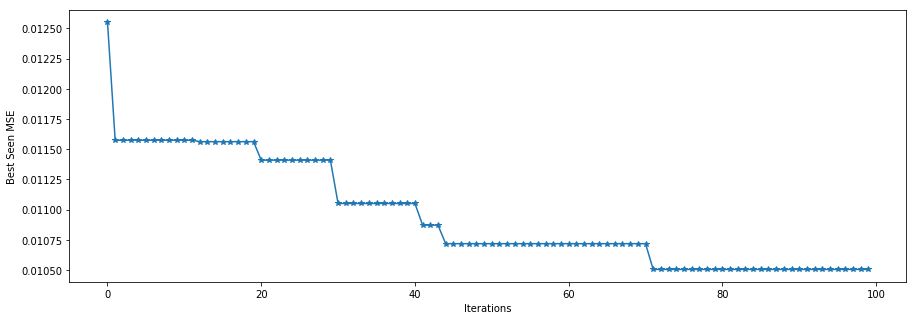

In [15]:
best_model = torch.load(path + "models/best_model_lstm_second_task")
results = pd.read_csv(path + "results/AutoML_LSTM_second_task.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [18]:
test_n = 1
look_back = 20

test_gen = dataloader([df_test[test_n].values], look_back, shuffle=False)
size = df_test[test_n].shape[0]

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, look_back + 1, 7)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_test = np.array(y_test).reshape(-1,4)
y_pred_all = y_pred_all.reshape(-1,4)

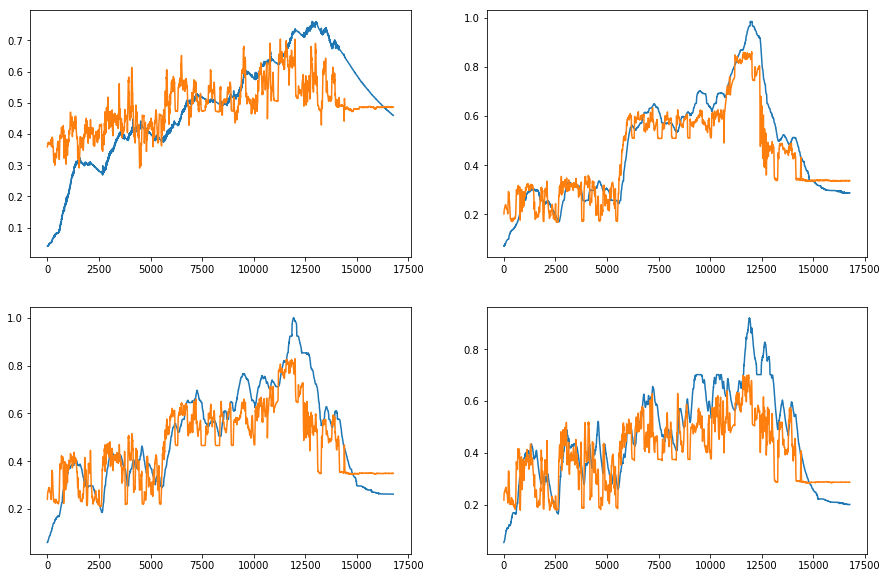

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:size - look_back - 1,0])
plt.plot(y_pred_all[:size - look_back - 1,0])

plt.subplot(222)
plt.plot(y_test[:size - look_back - 1,1])
plt.plot(y_pred_all[:size - look_back - 1,1])

plt.subplot(223)
plt.plot(y_test[:size - look_back - 1,2])
plt.plot(y_pred_all[:size - look_back - 1,2])

plt.subplot(224)
plt.plot(y_test[:size - look_back - 1,3])
plt.plot(y_pred_all[:size - look_back - 1,3])
plt.show()


plt.show()